# Runner example

This notebook will go through the options of the runner class. We will show how to fit and evaluate a model in parallel, and how to do cross-validation. 

This notebook is based off the blr_example notebook, and it is recommended to follow that notebook first.


### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_blr import NormBLR
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.blr.blr_conf import BLRConf
from pcntoolkit.regression_model.blr.blr import BLR
from pcntoolkit.util.runner import Runner
from pcntoolkit.util.plotter import plot_centiles, plot_qq
import seaborn as sns
import arviz as az

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [2]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)

In [3]:
data = pd.read_csv("resources/data/fcon1000.csv")

Plot the distribution of sex and site in the data.

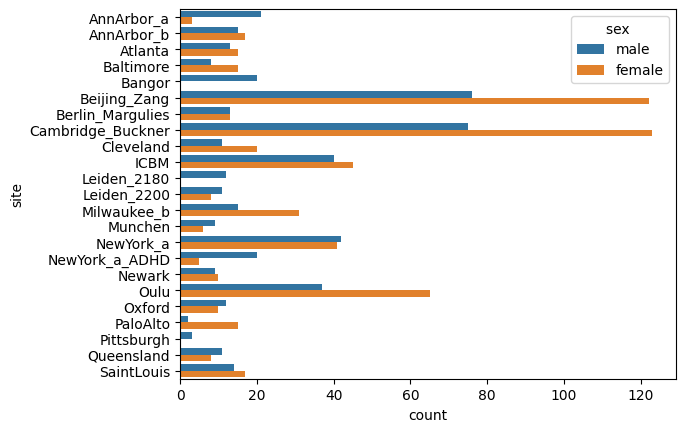

In [4]:
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()

Our HBR models will use random effects to model differences between sites. Because the random effects are best captured when there are enough samples of each effect in the data, we will have to remove some sites that are too small. We will filter out sites for which any of the sexes is represented by less than 10 samples

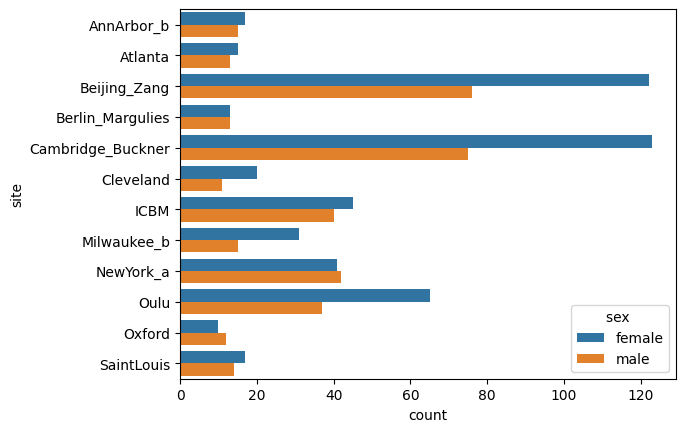

In [5]:
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")  # type: ignore
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index
data = data[~data["site"].isin(sites_with_one_sex.index)]
site_counts = site_counts[site_counts["counts"] < 10]
data = data[~data["site"].isin(site_counts["site"])]
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()


Now we load the data into a `NormData` object. 

In [6]:
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

We will use 2 sites for transfer (Milwaukee and Oulu) and the rest for training.

In [7]:
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects(
    {"site": transfer_sites}, names=["transfer", "fit"]
)


We also split the data into train and test sets.

In [8]:
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. Our `NormConf` configuration contains canonical paths, a standardization step for both the input as as the output data, and a Bspline basis expansion.

In [9]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/blr_kfold/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="linear",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Configuration of normative model is valid.


## Configure the regression model

BLR models are configured using a `BLRConf` object. 

In [10]:
blr_conf = BLRConf(
    optimizer="l-bfgs-b",
    n_iter=1000,
    heteroskedastic=True,
    random_intercept=True,
    warp="WarpSinhArcsinh",
    warp_reparam=True,
)

Configuration of regression model is valid.


## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [11]:
# Using the constructor
norm_blr = NormBLR(norm_conf=norm_conf, reg_conf=blr_conf)
display(norm_blr)
del norm_blr

In [12]:
# Using the factory method
norm_blr = create_normative_model(norm_conf, blr_conf)
norm_blr

## Fit the model
Normally we would just call 'fit_predict' on the model directly, but because we want to use the runner to do cross-validation in parallel, we need to first create a runner object. 

In [13]:
runner = Runner(
    cross_validate=True,
    cv_folds=10,
    parallelize=True,
    job_type="local",  # or "slurm" if you are on a slurm cluster
    n_jobs=2,
    log_dir="resources/blr_kfold/log_dir",
    temp_dir="resources/blr_kfold/temp_dir",
)

No python path specified. Using interpreter path of current process: /opt/anaconda3/envs/ptk_dev/bin/python


In [15]:
runner.fit_predict(norm_blr, train)

/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=3.66543e-82): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=2.33786e-82): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:615: RuntimeWarning: overflow encountered in divide
  J_transposed[i] = df / dx
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarnin

Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
61282 Saving model to resources/blr_kfold/save_dir/folds/fold_0
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_0/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
Computing centiles for WM-hypointensities


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_0/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_0/plots
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
61281 Saving model to resources/blr_kfold/save_dir/folds/fold_0
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_0/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_0/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_0/plots
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness
61282 Saving model to resources/blr_kfold/save_dir/folds/fold_1
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_1/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
61281 Saving model to resources/blr_kfold/save_dir/folds/fold_1
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_1/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=7.18769e-75): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=4.69998e-75): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=7.79764e-75): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/ptk_d

Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_1/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_1/plots
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_1/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_1/plots
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness
61282 Saving model to resources/blr_kfold/save_dir/folds/fold_2
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_2/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
Computing centiles for WM-hypointensities


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:282: RuntimeWarning: overflow encountered in divide
  beta = beta/(delta**2)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=5.35503e-104): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=3.42391e-104): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=5.90084e-104): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packa

61281 Saving model to resources/blr_kfold/save_dir/folds/fold_2
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_2/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_2/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_2/plots
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_2/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_2/plots
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanT

/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=3.0264e-99): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.91963e-99): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:615: RuntimeWarning: overflow encountered in divide
  J_transposed[i] = df / dx
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill

Computing centiles for WM-hypointensities
Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_3/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_3/plots
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_3/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_3/plots
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
61281 Saving model to resources/blr_kfold/save_dir/folds/fold_4
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_4/model


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=7.70478e-77): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=4.94179e-77): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=8.47634e-77): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/ptk_d

Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
61282 Saving model to resources/blr_kfold/save_dir/folds/fold_4
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_4/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_4/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_4/plots
Going to fit and predict 1 models
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_4/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_4/plots
Fi

/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=3.77208e-98): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=2.40215e-98): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:615: RuntimeWarning: overflow encountered in divide
  J_transposed[i] = df / dx
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Il

Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_5/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_5/plots
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_5/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_5/plots
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
61281 Saving model to resources/blr_kfold/save_dir/folds/fold_6
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_6/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanT

/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.80542e-66): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.14907e-66): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.96644e-66): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_d

Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_6/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_6/plots
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_6/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_6/plots
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
61281 Saving model to resources/blr_kfold/save_dir/folds/fold_7
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_7/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanT

/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.39931e-79): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=8.9278e-80): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:615: RuntimeWarning: overflow encountered in divide
  J_transposed[i] = df / dx
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill

Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_7/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_7/plots
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_7/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_7/plots
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=4.30698e-27): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=2.698e-27): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=4.43336e-27): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/ptk_dev

61282 Saving model to resources/blr_kfold/save_dir/folds/fold_8
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_8/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
61281 Saving model to resources/blr_kfold/save_dir/folds/fold_8
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_8/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_8/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_8/plots
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/b

/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:282: RuntimeWarning: overflow encountered in divide
  beta = beta/(delta**2)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=7.92629e-134): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=5.03574e-134): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=8.74873e-134): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packa

Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_9/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_9/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_9/plots
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_9/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_9/plots

All jobs completed!


If the runner is running under cross-validation, the results for each fold are stored in the save_dir/folds/fold_i folder. There we will find the usual three subfolders:
- `model`: contains the model and metadata
- `results`: containing csv files with the evaluation results for all response variables
- `plots`: containing qq plots and centile plots for each response variable

### Loading a fold model
We can load a fold model by calling `load_fold_model` on the runner object. This will return a `NormHBR` object, which we can inspect and use to predict on new data.

In [16]:
fold_model = runner.load_fold_model(0)
fold_model.predict(test)

display(fold_model)

Configuration of normative model is valid.
Configuration of normative model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness
Predicting model for WM-hypointensities
Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_0/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr_kfold/save_dir/folds/fold_0/plots


## Inspecting the model 

The norm_blr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_blr.regression_models.get("{responsevar}")`

In [17]:
model = fold_model.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.__dict__

{'_name': 'rh_MeanThickness_thickness',
 '_reg_conf': BLRConf(n_iter=1000, tol=1e-05, ard=False, optimizer='l-bfgs-b', l_bfgs_b_l=0.1, l_bfgs_b_epsilon=0.1, l_bfgs_b_norm='l2', intercept=False, random_intercept=True, heteroskedastic=True, intercept_var=False, random_intercept_var=False, warp='WarpSinhArcsinh', warp_reparam=True),
 'is_fitted': True,
 '_is_from_dict': True,
 'hyp': array([-2.91140173e-01, -1.25354966e-01,  1.02384524e-01,  1.33400352e-03,
         2.58781210e-03,  2.56395544e-03,  1.70354072e-03, -3.64543990e-04,
         2.49163850e-03,  1.41572966e-03,  1.92115689e-03,  2.37499422e-03,
        -1.58065817e-04,  2.18896731e-03,  2.35602063e-03,  1.31655636e-03]),
 'nlZ': 653.2551095706003,
 'N': 528,
 'D': 13,
 'lambda_n_vec': array([1.5444605 , 1.52813159, 1.51197532, 1.49598987, 1.48017343,
        1.4645242 , 1.44904043, 1.43372036, 1.41856226, 1.40356442,
        1.38872515, 1.37404277, 1.35951561, 1.34514205, 1.33092045,
        1.31684921, 1.30292674, 1.28915147,

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [18]:
display(test.measures.to_pandas().T)

response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.485359,0.470793
RMSE,0.077665,465.186623
SMSE,0.620067,0.663538
ExpV,0.380686,0.349498
NLL,NaN,NaN
ShapiroW,0.989097,0.993464


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [19]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
124,0.453093,0.827119
48,-0.208713,-0.615560
545,0.704747,0.186060
847,0.783858,0.312643
360,-1.953704,-0.233791
...,...,...
688,-1.218207,0.127543
420,0.811121,0.876557
123,-0.666224,-1.017330


In [20]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
124                             2.355706         469.663507   
48                              2.301839         395.611722   
545                             2.237263        -262.491402   
847                             2.328620         446.282634   
360                             2.346880         695.958745   
...                                  ...                ...   
688                             2.330179         331.017512   
420                             2.363023         645.323031   
123                             2.377316         575.302498   
276                             2.392585         142.799513   
183                             2.366525         487.254237   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
124                             2.429040         750.641682   
48                              2.372098         668.964311   
545                             2.338453         514.566216   
847                             2.407104         810.375413   
360                             2.419359        1034.170456   
...                                  ...                ...   
688                             2.412022         729.562263   
420                             2.432904         912.373075   
123                             2.451514         857.384238   
276                             2.477375         428.404839   
183                             2.439332         751.556910   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
124                             2.485997         986.116699   
48                              2.424497         892.548203   
545                             2.414616        1392.079544   
847                             2.467625        1142.276457   
360                             2.475264        1359.079634   
...                                  ...                ...   
688                             2.475648        1092.471893   
420                             2.487013        1143.033706   
123                             2.509625        1100.677677   
276                             2.544023         653.235759   
183                             2.496098         970.444242   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
124                             2.548159        1291.292254   
48                              2.482149        1171.159158   
545                             2.501482        3764.883245   
847                             2.535104        1658.336557   
360                             2.536832        1860.642210   
...                                  ...                ...   
688                             2.546441        1678.942381   
420                             2.545786        1450.366279   
123                             2.571176        1428.218264   
276                             2.611655         917.642762   
183                             2.557280        1247.127089   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


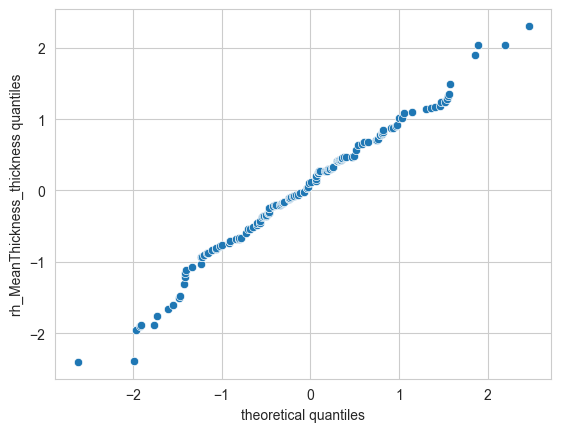

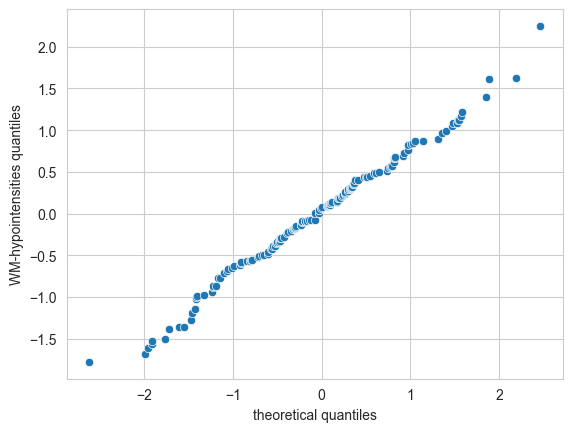

In [21]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

In [22]:
plot_centiles(
    norm_blr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

KeyError: None

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


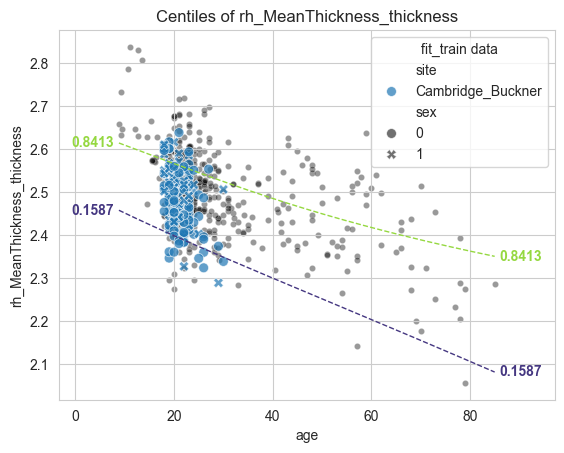

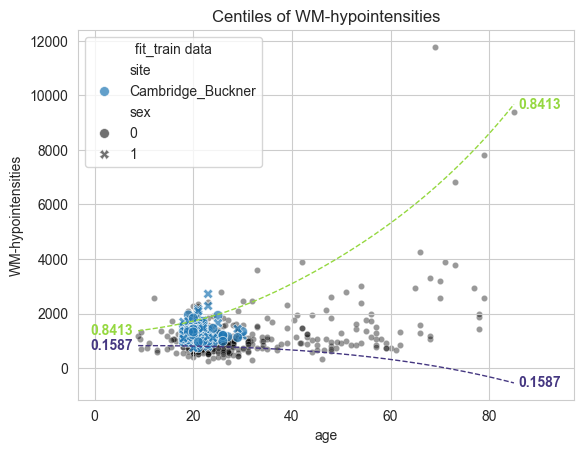

In [23]:
plot_centiles(
    fold_model,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Cambridge_Buckner"]},
)

And that's it, now you have seen how to:
- Use the runner to do cross-validation in parallel
- Inspect the model of a specific fold
- Evaluate the model on a test set
- Create useful plots

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!
